# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

/home/icb/amirali.moinfar/miniconda3/envs/drvi_repr/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/amirali.moinfar/miniconda3/envs/drvi_repr/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/amirali.moinfar/miniconda3/envs/drvi_repr/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/amirali.moinfar/miniconda3/envs/drvi_repr/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/icb/amirali.moinfar/miniconda3/e

In [3]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [4]:
import os
import sys
import argparse
import pickle

import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

import drvi
from drvi.utils.metrics import (most_similar_averaging_score, latent_matching_score, most_similar_gap_score,
    nn_alignment_score, local_mutual_info_score, spearman_correlataion_score)
from drvi_notebooks.utils.data.adata_plot_pp import make_balanced_subsample
from drvi_notebooks.utils.data.data_configs import get_data_info
from drvi_notebooks.utils.run_info import get_run_info_for_dataset
from drvi_notebooks.utils.method_info import pretify_method_name
from drvi_notebooks.utils.latent import set_optimal_ordering

Merlin is not installed. To use merline dataloader please install it.


In [5]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

# Config

In [6]:
parser = argparse.ArgumentParser()

parser.add_argument('--run-name', type=str)

interactive = False
if hasattr(sys, 'ps1'):
    args = parser.parse_args("--run-name immune_hvg".split(" "))
    interactive = True
else:
    args = parser.parse_args()
print(args)

Namespace(run_name='immune_hvg')


In [7]:
cwd = os.getcwd()
cwd

'/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public/drvi_notebooks/evaluation'

In [8]:
proj_dir = Path(cwd).parent.parent
proj_dir

PosixPath('/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public')

In [9]:
logs_dir = Path(os.path.expanduser('~/workspace/train_logs'))
logs_dir

PosixPath('/home/icb/amirali.moinfar/workspace/train_logs')

In [10]:
run_name = args.run_name
real_run_name = run_name
if run_name == 'zebrafish_hvg_128':
    real_run_name = 'zebrafish_hvg'
if run_name in ['michigan_immune_param_optimization']:
    real_run_name = 'immune_hvg'
if run_name.endswith("_ablation"):
    real_run_name = run_name[:-len("_ablation")]
if run_name in ['immune_all_hbw_ablation']:
    real_run_name = 'immune_all'
run_version = '4.3'
run_path = os.path.expanduser('~/workspace/train_logs/models')

data_info = get_data_info(real_run_name, run_version)
wandb_address = data_info['wandb_address']
col_mapping = data_info['col_mapping']
plot_columns = data_info['plot_columns']
pp_function = data_info['pp_function']
data_path = data_info['data_path']
var_gene_groups = data_info['var_gene_groups']
cell_type_key = data_info['cell_type_key']
exp_plot_pp = data_info['exp_plot_pp']
control_treatment_key = data_info['control_treatment_key']
condition_key = data_info['condition_key']
split_key = data_info['split_key']

In [11]:
import mplscience
mplscience.available_styles()
mplscience.set_style()

['default', 'despine']


In [12]:
cat_10_pallete = sc.plotting.palettes.vega_10_scanpy
cat_20_pallete = sc.plotting.palettes.vega_20_scanpy
wong_pallete = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000",
]
cat_100_pallete = sc.plotting.palettes.godsnot_102

In [13]:
# Sometimes rapid_single_cell UMAP creates some outliers.
def trim_umap(embed, old_key='X_umap', new_key='X_umap', threshold=1e-5):
    x_min, x_max = np.quantile(embed.obsm[old_key][:, 0], (threshold, 1-threshold))
    x_min, x_max = float(x_min), float(x_max)
    y_min, y_max = np.quantile(embed.obsm[old_key][:, 1], (threshold, 1-threshold))
    y_min, y_max = float(y_min), float(y_max)
    embed.obsm[new_key] = np.vstack([embed.obsm[new_key][:, 0].clip(x_min, x_max), embed.obsm['X_umap'][:, 1].clip(y_min, y_max)]).T

## Runs to load

In [14]:
run_info = get_run_info_for_dataset(run_name)
RUNS_TO_LOAD = run_info.run_dirs
scatter_point_size = run_info.scatter_point_size
adata_to_transfer_obs = run_info.adata_to_transfer_obs

for k,v in RUNS_TO_LOAD.items():
    if not os.path.exists(v):
        raise ValueError(f"{v} does not exists.")

In [15]:
RUNS_TO_LOAD

{'DRVI': PosixPath('/home/icb/amirali.moinfar/workspace/train_logs/models/drvi_20240430-115959-272081'),
 'DRVI-IK': PosixPath('/home/icb/amirali.moinfar/workspace/train_logs/models/drvi_20240430-120129-576776'),
 'scVI': PosixPath('/home/icb/amirali.moinfar/workspace/train_logs/models/scvi_20240430-114522-508980'),
 'PCA': PosixPath('/home/icb/amirali.moinfar/workspace/train_logs/models/clear-meadow-12'),
 'ICA': PosixPath('/home/icb/amirali.moinfar/workspace/train_logs/models/apricot-feather-12'),
 'MOFA': PosixPath('/home/icb/amirali.moinfar/workspace/train_logs/models/robust-universe-14'),
 'TCVAE-opt': PosixPath('/home/icb/amirali.moinfar/io/michigan/michigan_embed_immune_hvg_32_run_opt_tcvae_final.h5ad'),
 'MICHIGAN-opt': PosixPath('/home/icb/amirali.moinfar/io/michigan/michigan_embed_immune_hvg_32_run_opt_michigan_final.h5ad'),
 'DRVI-CVAE': PosixPath('/home/icb/amirali.moinfar/workspace/train_logs/models/drvi_20240430-120143-193655')}

In [16]:
embeds = {}
random_order = None
for method_name, run_path in RUNS_TO_LOAD.items():
    print(method_name)
    if str(run_path).endswith(".h5ad"):
        embed = sc.read(run_path)
    else:
        embed = sc.read(run_path / 'latent.h5ad')
    if embed.n_vars > 512:
        embed = embed[:, np.abs(embed.X).max(axis=0) > 0.1].copy()
    trim_umap(embed, threshold=1e-3)
    pp_function(embed)
    set_optimal_ordering(embed, key_added='optimal_var_order', metric='euclidean+')
    if random_order is None:
        random_order = embed.obs.sample(frac=1.).index
    embed = embed[random_order].copy()
    embeds[method_name] = embed
    if adata_to_transfer_obs is not None:
        for col in adata_to_transfer_obs.obs.columns:
            if col not in embed.obs.columns:
                embed.obs[col] = adata_to_transfer_obs.obs[col]

DRVI
DRVI-IK
scVI
PCA
ICA
MOFA
TCVAE-opt
MICHIGAN-opt
DRVI-CVAE


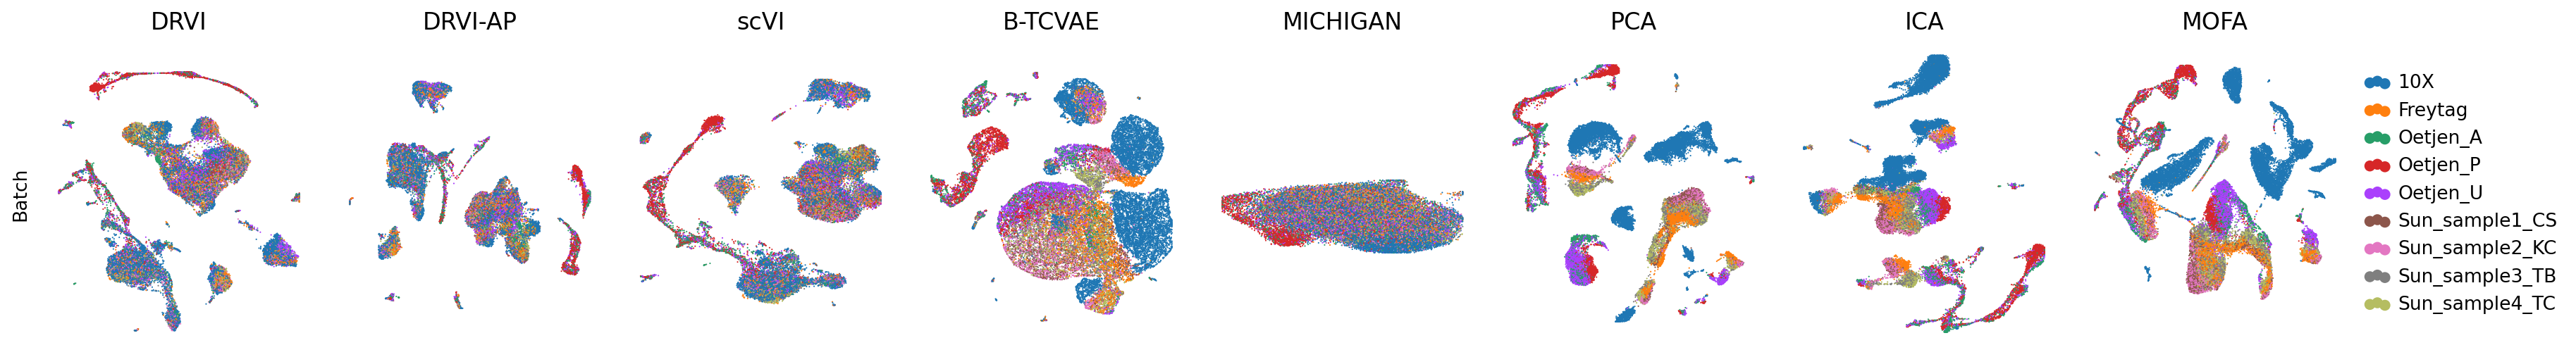

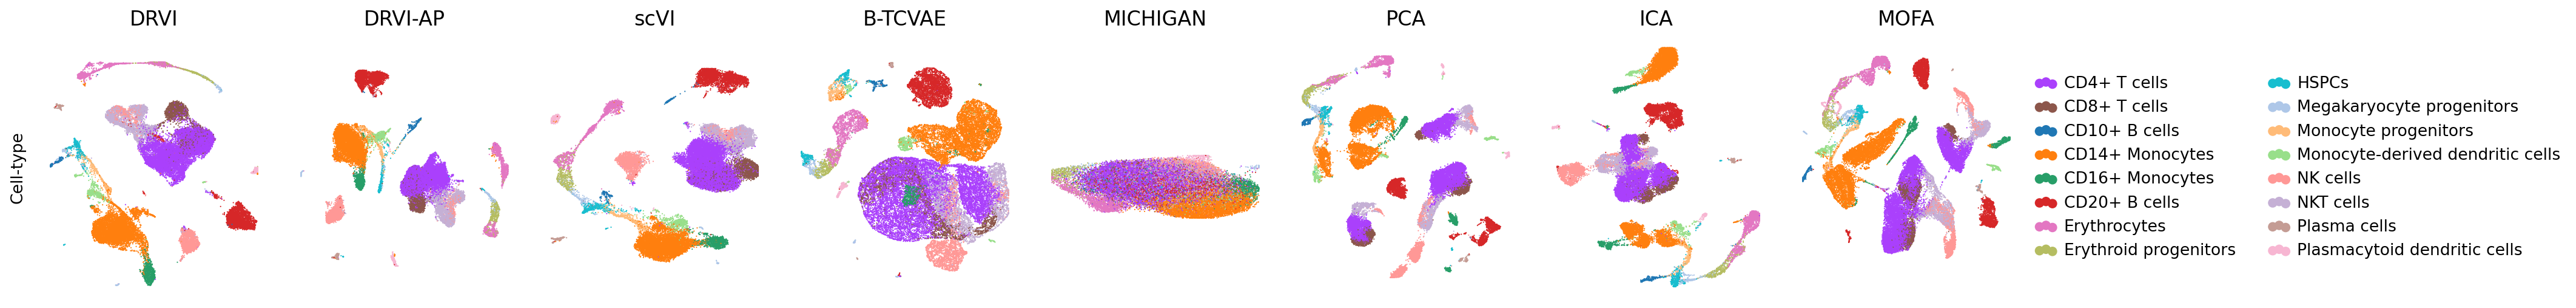

In [17]:
size = 3
if run_name == 'atac_nips21':
    methods_to_plot = ["DRVI", "DRVI-IK", "PeakVI", "PoissonVI"]
elif real_run_name == run_name:
    methods_to_plot = ["DRVI", "DRVI-IK", "scVI", "TCVAE-opt", "MICHIGAN-opt", "PCA", "ICA", "MOFA"]
else:
    methods_to_plot = list(embeds.keys())

# n_col = len(embeds)
n_col = len(methods_to_plot)
for _, col in enumerate(plot_columns):
    fig,axs=plt.subplots(1, n_col,
                     figsize=(n_col * size, 1 * size),
                     sharey='row', squeeze=False)
    j = 0
    # for i, (method_name, embed) in enumerate(embeds.items()):
    for i, method_name in enumerate(methods_to_plot):
        embed = embeds[method_name]
    
        pos = (-0.1, 0.5)
        
        ax = axs[j, i]
        unique_values = list(sorted(list(embed.obs[col].astype(str).unique())))
        # if len(unique_values) <= 8:
        #     palette = dict(zip(unique_values, wong_pallete))
        if len(unique_values) <= 10:
            palette = dict(zip(unique_values, cat_10_pallete))
        elif len(unique_values) <= 20:
            palette = dict(zip(unique_values, cat_20_pallete))
        elif len(unique_values) <= 102:
            palette = dict(zip(unique_values, cat_100_pallete))
        else:
            palette = None
        sc.pl.umap(embed, color=col, 
                   palette=palette, 
                   ax=ax, show=False, frameon=False, title='' if j != 0 else pretify_method_name(method_name), 
                   legend_loc='none' if i != n_col - 1 else 'right margin',
                   colorbar_loc=None if i != n_col - 1 else 'right')
        if len(unique_values) > 30:
            if i == n_col - 1:
                ax.legend(ncol=len(unique_values)//15+1, bbox_to_anchor=(1.1, 1.05))
        if i == 0:
            ax.annotate(col_mapping[col], zorder=100, fontsize=12,
                        xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')

    plt.subplots_adjust(left=0.1,
                        bottom=0.05,
                        right=0.95,
                        top=0.95,
                        wspace=0.1,
                        hspace=0.1)
    
    plt.savefig(proj_dir / 'plots' / f'eval_disentanglement_{run_name}_umaps_{col}.pdf', bbox_inches='tight')

DRVI
batch


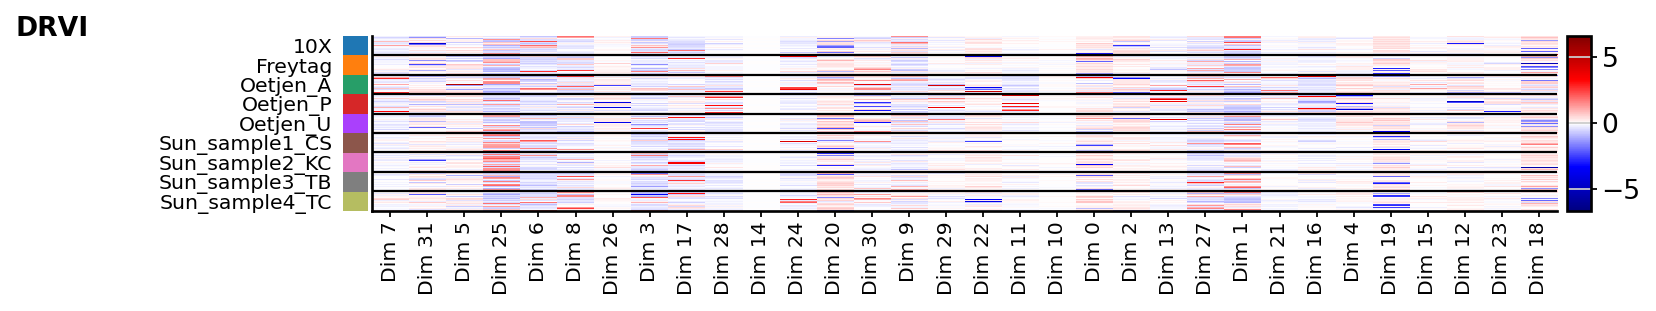

final_annotation


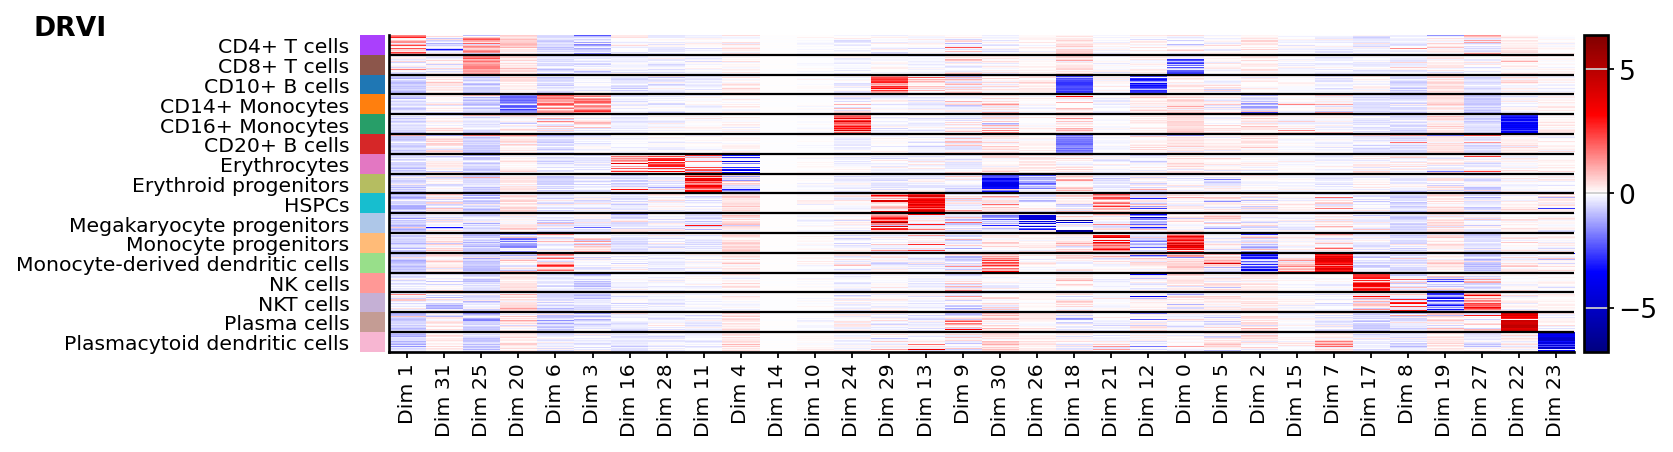

DRVI-IK
batch


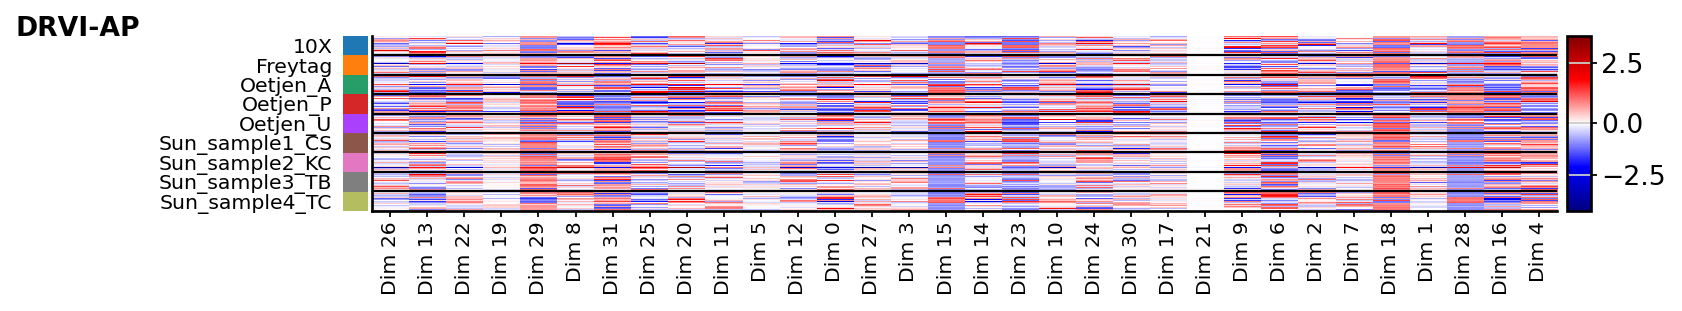

final_annotation


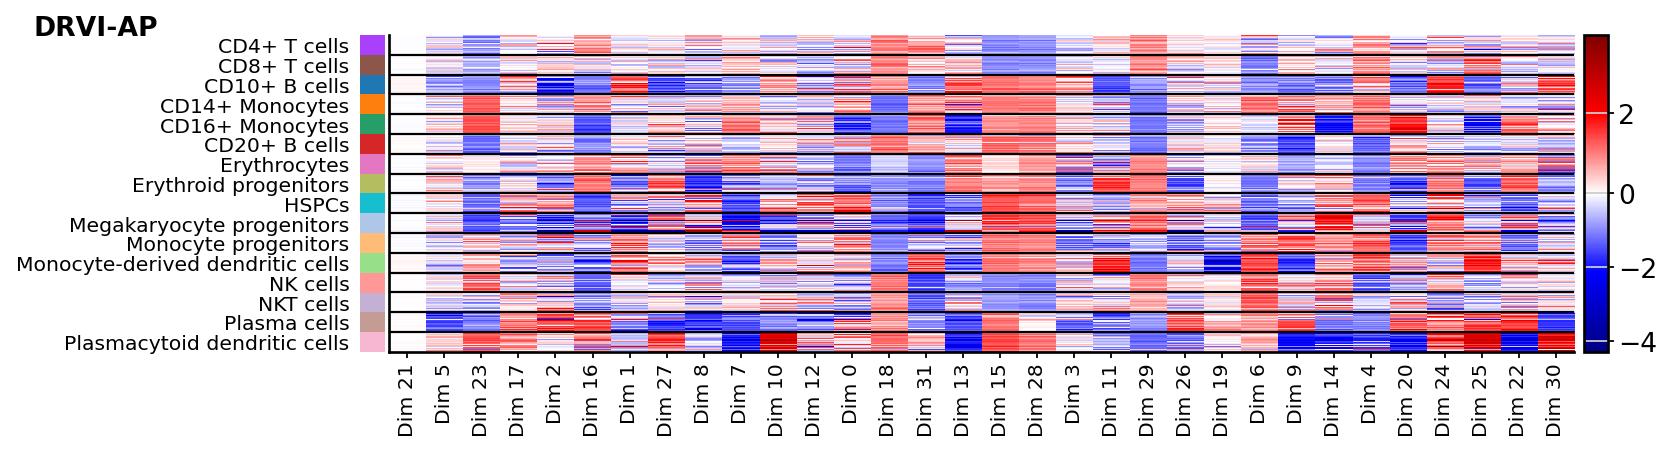

scVI
batch


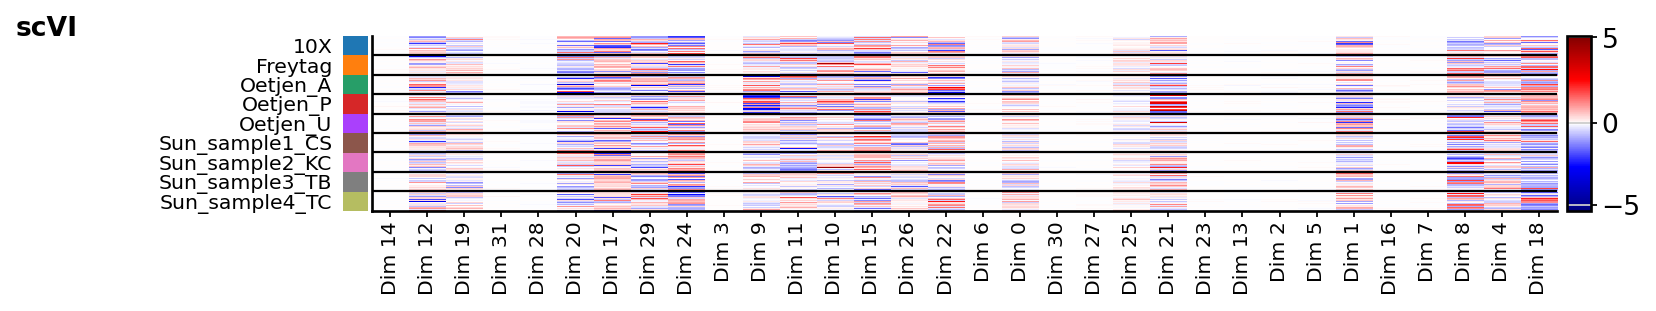

final_annotation


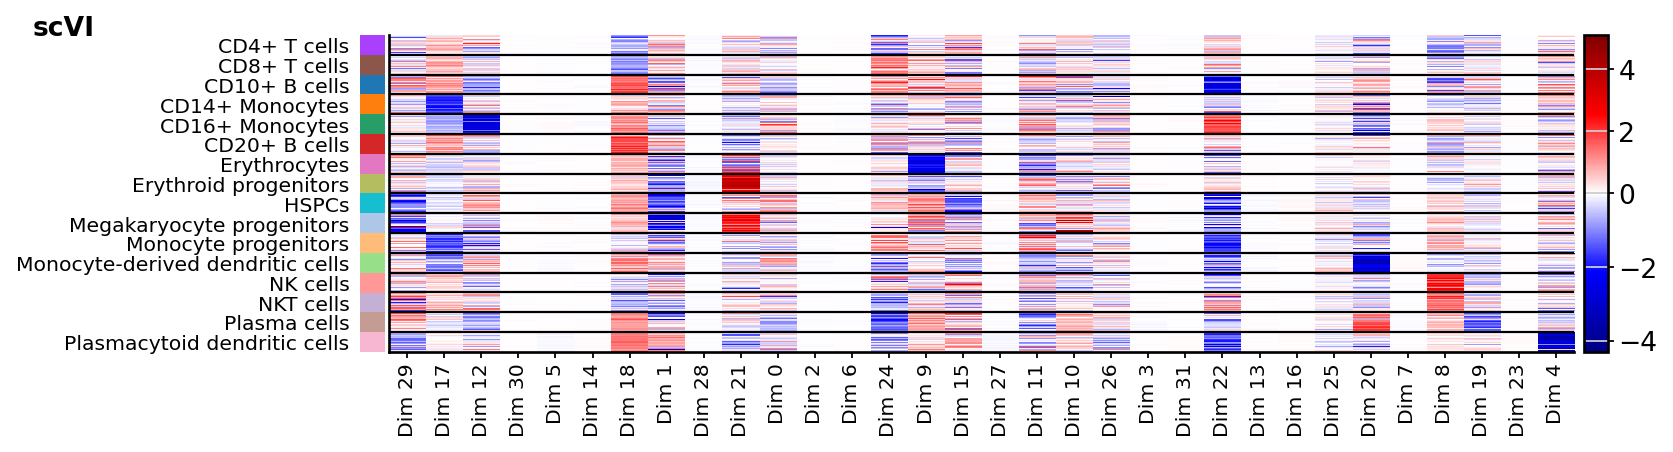

PCA
batch


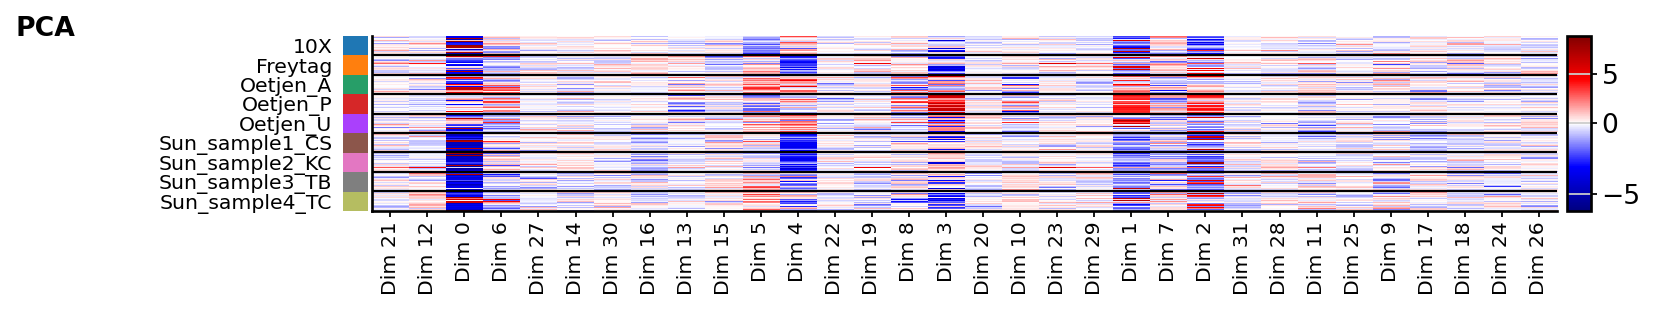

final_annotation


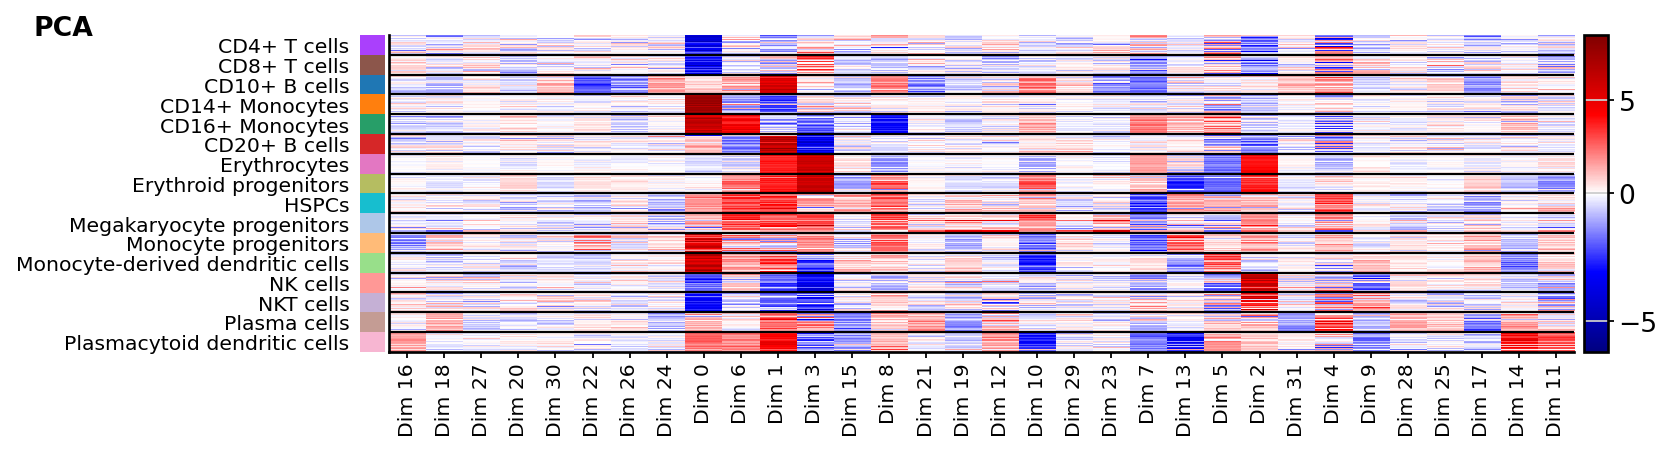

ICA
batch


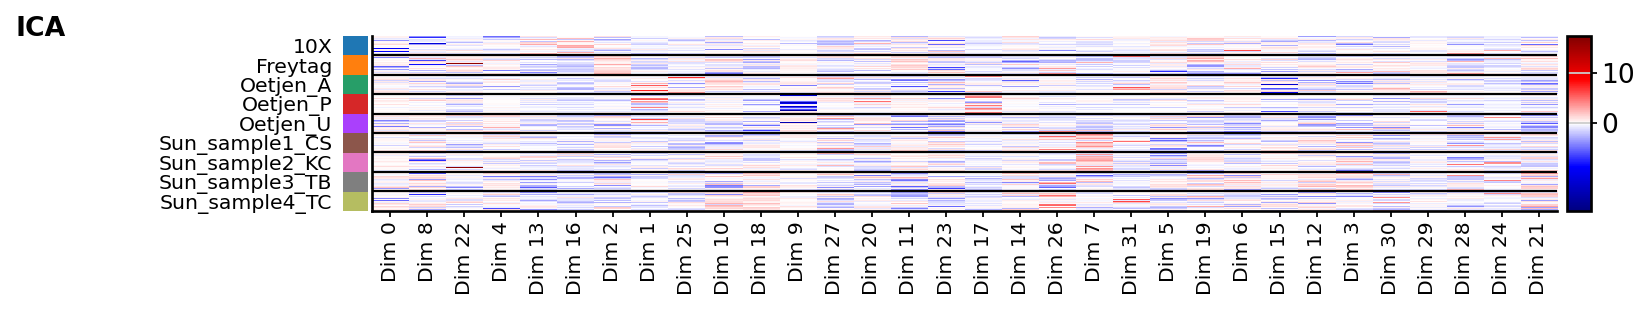

final_annotation


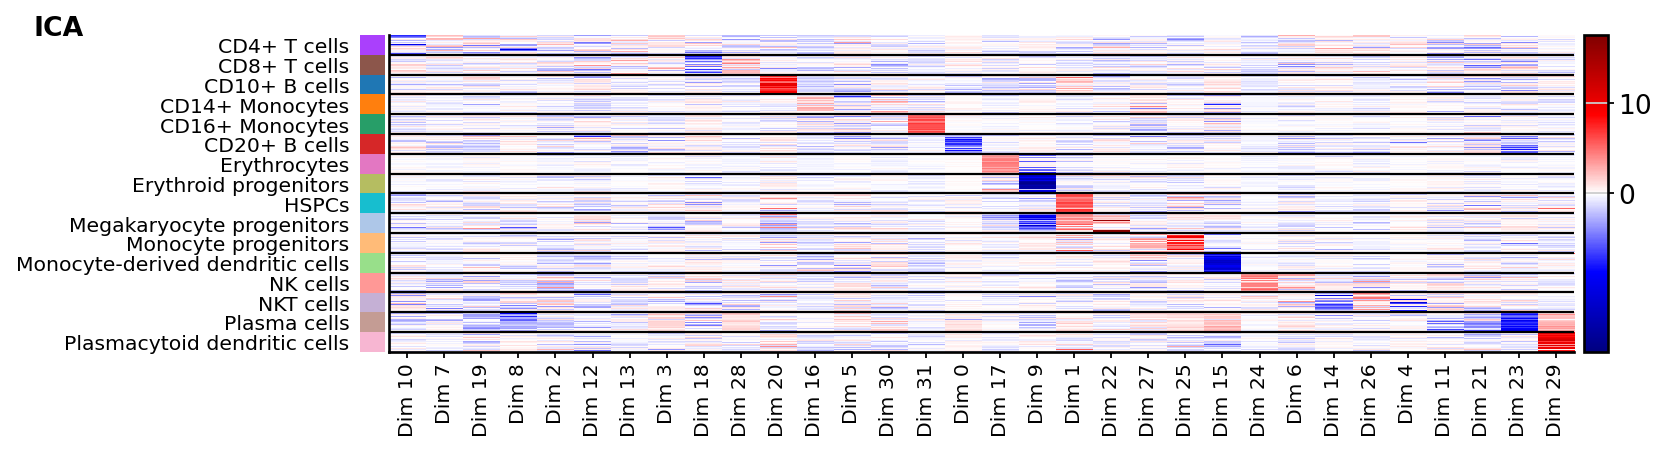

MOFA
batch


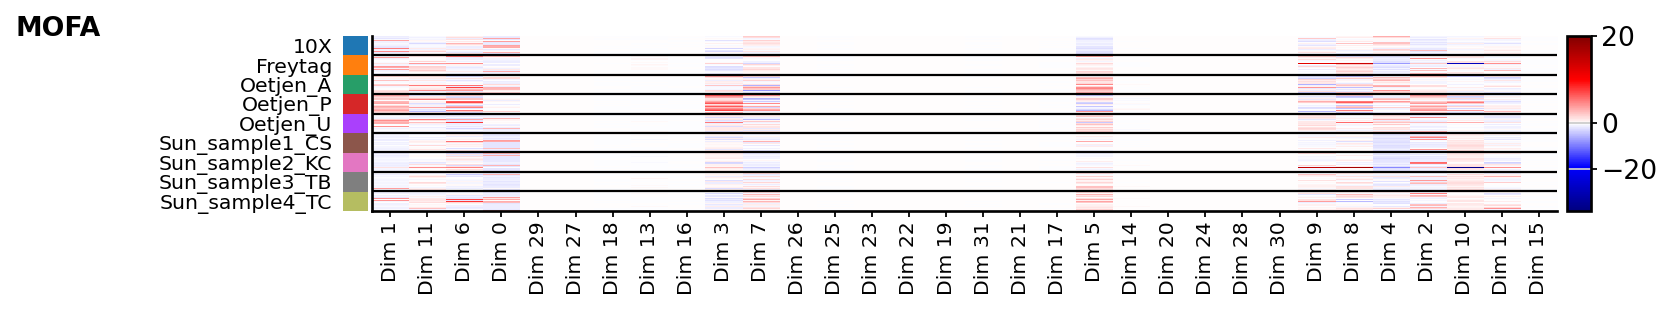

final_annotation


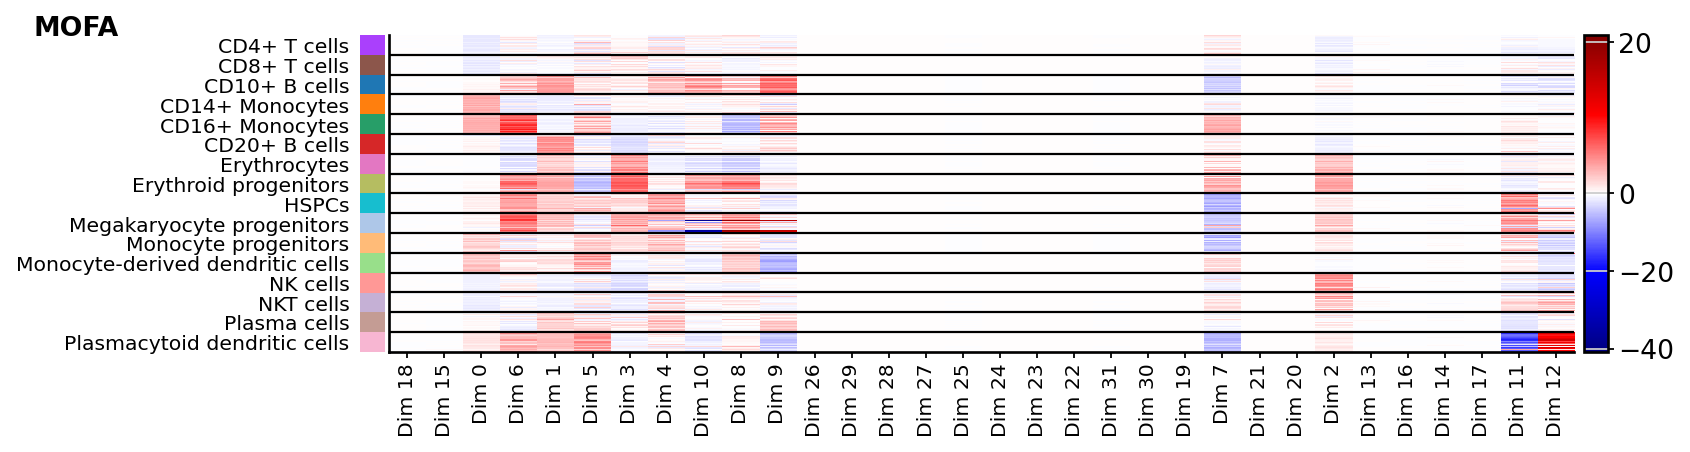

TCVAE-opt
batch


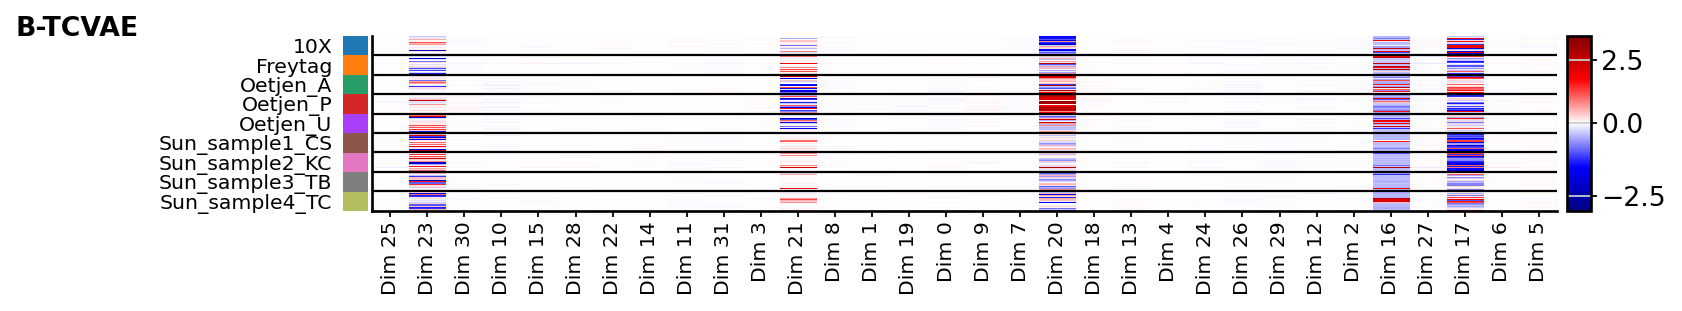

final_annotation


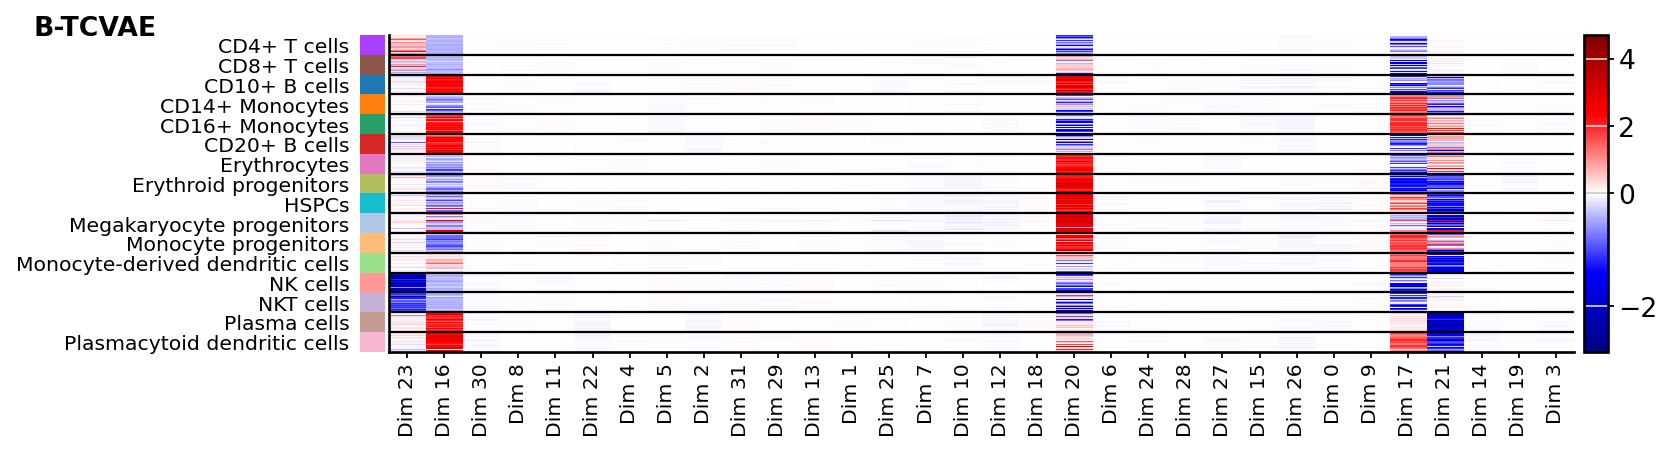

MICHIGAN-opt
batch


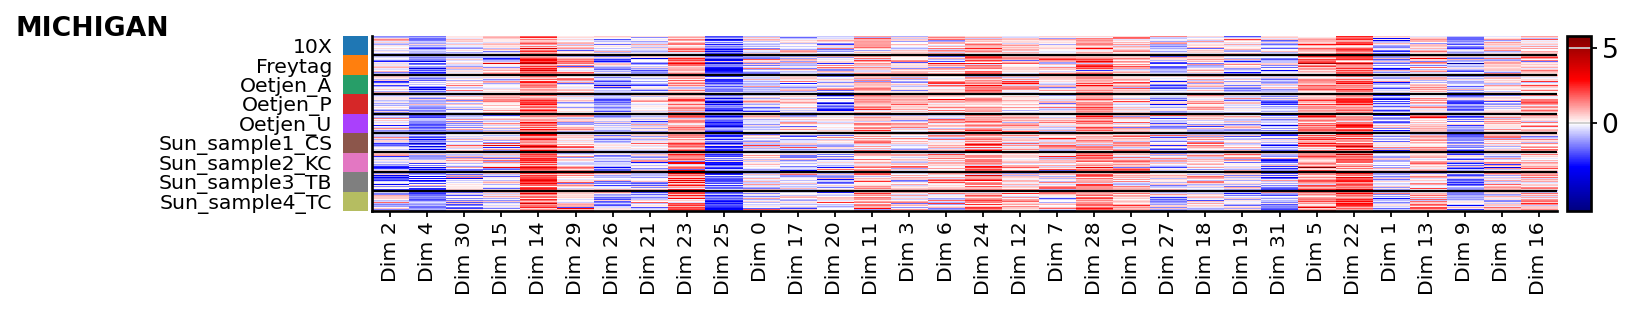

final_annotation


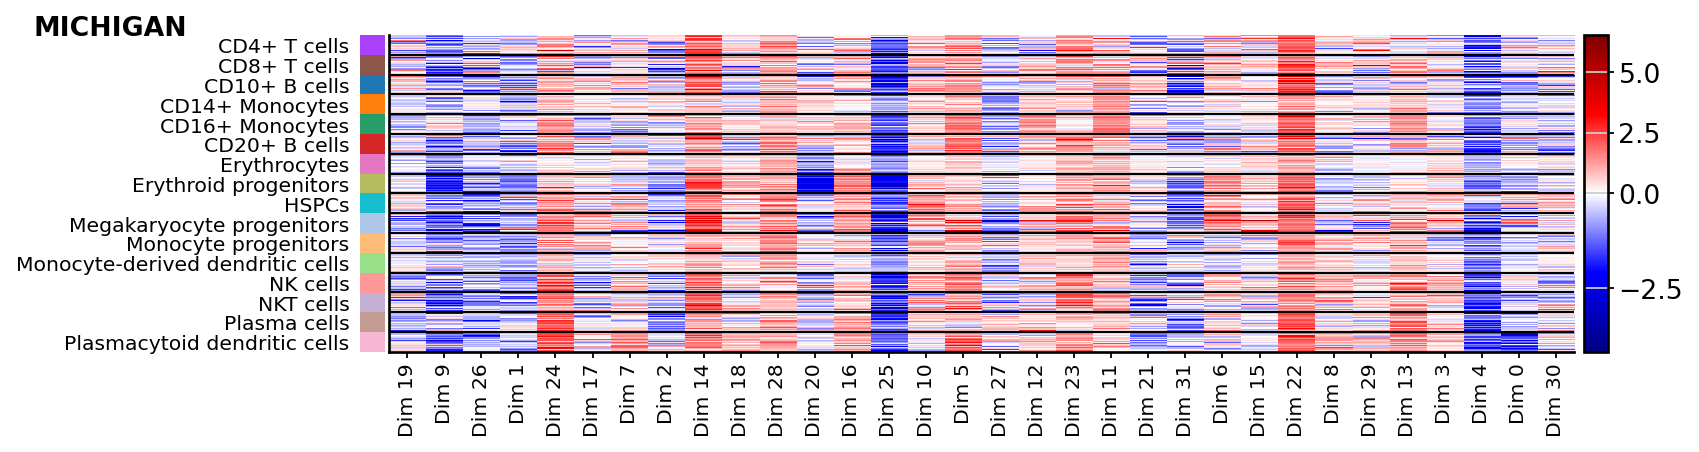

DRVI-CVAE
batch


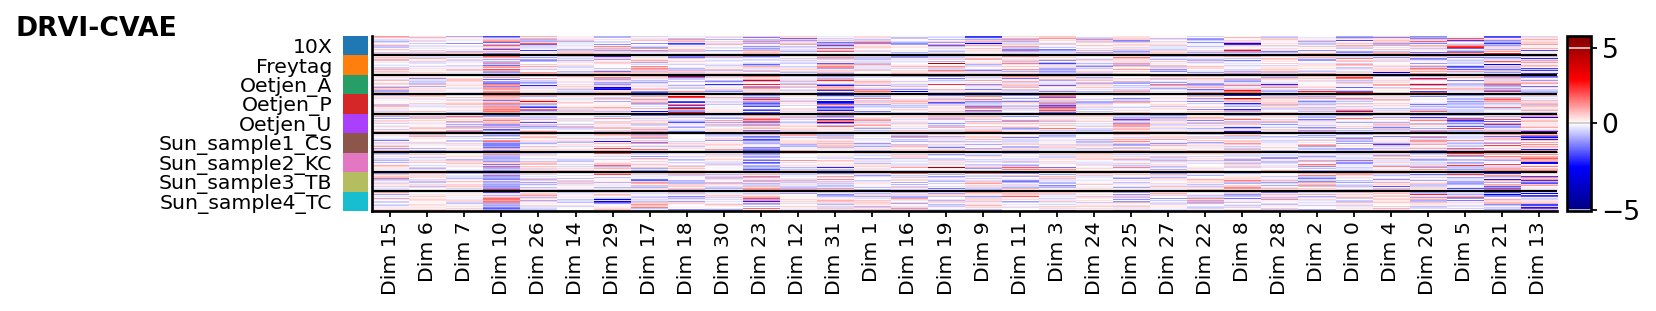

final_annotation


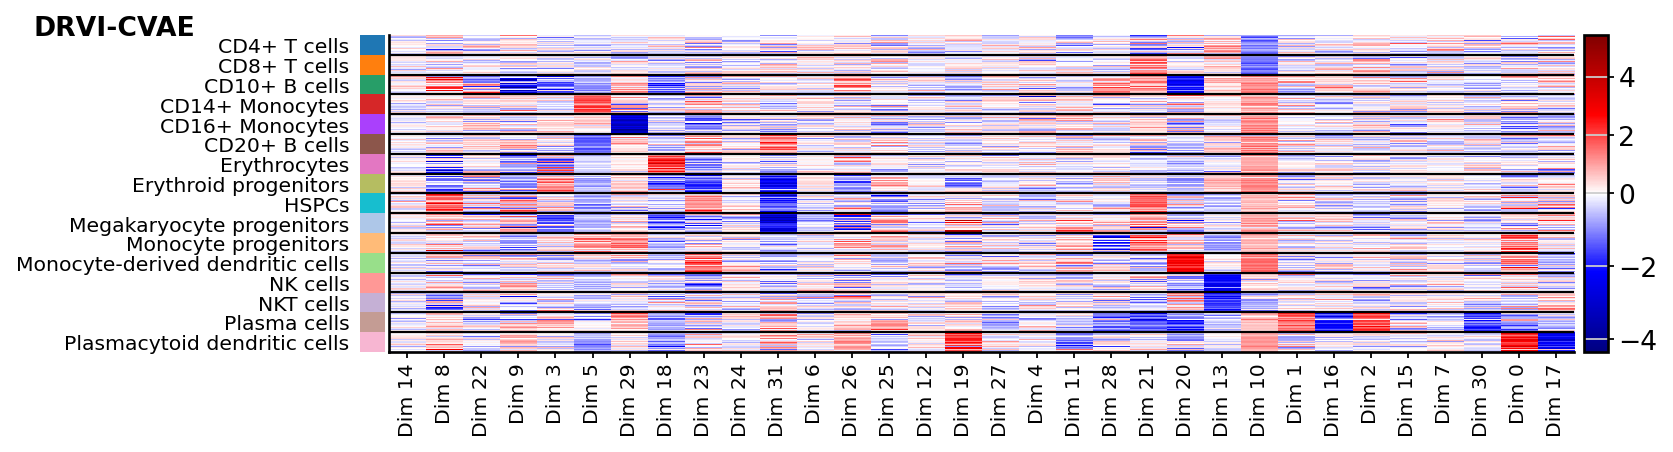

In [18]:
for method_name, run_path in RUNS_TO_LOAD.items():
    print(method_name)
    embed = embeds[method_name]
    for k in plot_columns:
        print(k)
        if embed.obs[k].dtype in [np.float32, np.float64]:
            continue
        embed_balanced = make_balanced_subsample(embed, k)
        dim_order = np.abs(embed_balanced.X).argmax(axis=0).argsort().tolist()
        embed_balanced.var['dim_title'] = np.char.add('Dim ', np.arange(embed.n_vars).astype(str))
        g = sc.pl.heatmap(
            embed_balanced,
            embed_balanced.var.iloc[dim_order]['dim_title'],
            k,
            gene_symbols='dim_title',
            layer=None,
            figsize=(10, len(embed.obs[k].unique()) / 6),
            var_group_rotation=45,
            show_gene_labels=True,
            # dendrogram='+' not in col_mapping[k],
            vcenter=0, # vmin=-4, vmax=4,
            cmap=drvi.utils.pl.cmap.saturated_red_blue_cmap,
            show=False,
        )
        ax = g['heatmap_ax']
        g['groupby_ax'].set_ylabel('')
        ax.text(-0.3, 1., pretify_method_name(method_name), size=12, ha='left', weight='bold', color='black', rotation=0, transform=ax.transAxes)
        plt.savefig(proj_dir / 'plots' / f'eval_disentanglement_{run_name}_heatmap_{k}_{method_name}.pdf', bbox_inches='tight')
        plt.show()

In [19]:
metrics = {
    'Absolute Spearman Correlation': spearman_correlataion_score,
    'NN Alignment': nn_alignment_score,
    'Mutual Info Score': local_mutual_info_score,
}
METRICS_NEEDING_SAMPLING = ['Mutual Info Score']

In [20]:
noise = 0e-1
max_samples = None
min_sample_per_cat = 10

def calculate_metrics_for_embedding(embedding_array, ct_cat_series, sampling_mask=None):
    print('.', end='', flush=True)
    embedding_array = embedding_array + np.random.randn(*embedding_array.shape) * noise
    n_vars = embedding_array.shape[1]
    results = dict()
    for metric_name, metric_func in metrics.items():
        if sampling_mask is not None and metric_name in METRICS_NEEDING_SAMPLING:
            results[metric_name] = metric_func(embedding_array[sampling_mask], ct_cat_series[sampling_mask])
        else:
            results[metric_name] = metric_func(embedding_array, ct_cat_series)
        if len(results[metric_name].shape) == 1:
            results[metric_name] = pd.DataFrame({'metric': results[metric_name]}, index=[f"dim_{d}" for d in range(embedding_array.shape[1])])
        else:
            results[metric_name] = pd.DataFrame(results[metric_name], 
                                                index=[f"dim_{d}" for d in range(embedding_array.shape[1])], 
                                                columns=ct_cat_series.cat.categories)
    
    return results

In [21]:
%%time
any_embed = list(embeds.values())[0]
if max_samples is not None and any_embed.shape[0] > max_samples:
    np.random.seed(seed=1)
    min_sample_per_cat = any_embed.obs[cell_type_key].value_counts().min()
    balanced_sample_index = (
        any_embed.obs[[cell_type_key]]
        .groupby(cell_type_key)
        .sample(n=min_sample_per_cat, random_state=0, replace=min_sample_per_cat < min_sample_per_cat)
        .index
    ).unique()
    if max_samples > len(balanced_sample_index):
        random_ids = any_embed.obs.index[np.random.choice(any_embed.shape[0], size=max_samples - len(balanced_sample_index), replace=False)]
        random_ids = balanced_sample_index.union(random_ids).unique()
    else:
        random_ids = balanced_sample_index
else:
    random_ids = any_embed.obs.index[np.arange(any_embed.shape[0])]

sampling_mask = any_embed.obs.index.isin(random_ids)

noise_condition = "no_noise" if noise == 0. else "with_noise"
metric_results_pkl_address = proj_dir / 'results' / f'eval_disentanglement_fine_metric_results_{run_name}_{noise_condition}.pkl'
if not os.path.exists(metric_results_pkl_address):
    metric_results = {
        method_name: calculate_metrics_for_embedding(embed.X, embed.obs[cell_type_key], sampling_mask)
        for method_name, embed in embeds.items()
    }
    with open(metric_results_pkl_address, 'wb') as f:
        pickle.dump(metric_results, f)
else:
    with open(metric_results_pkl_address, 'rb') as f:
        metric_results = pickle.load(f)
    new_metric_results = {
        method_name: calculate_metrics_for_embedding(embed.X, embed.obs[cell_type_key], sampling_mask)
        for method_name, embed in embeds.items()
        if method_name not in metric_results
    }
    if len(new_metric_results) > 0:
        metric_results.update(new_metric_results)
        with open(metric_results_pkl_address, 'wb') as f:
            pickle.dump(metric_results, f)

CPU times: user 9.95 ms, sys: 2.81 ms, total: 12.8 ms
Wall time: 24.9 ms


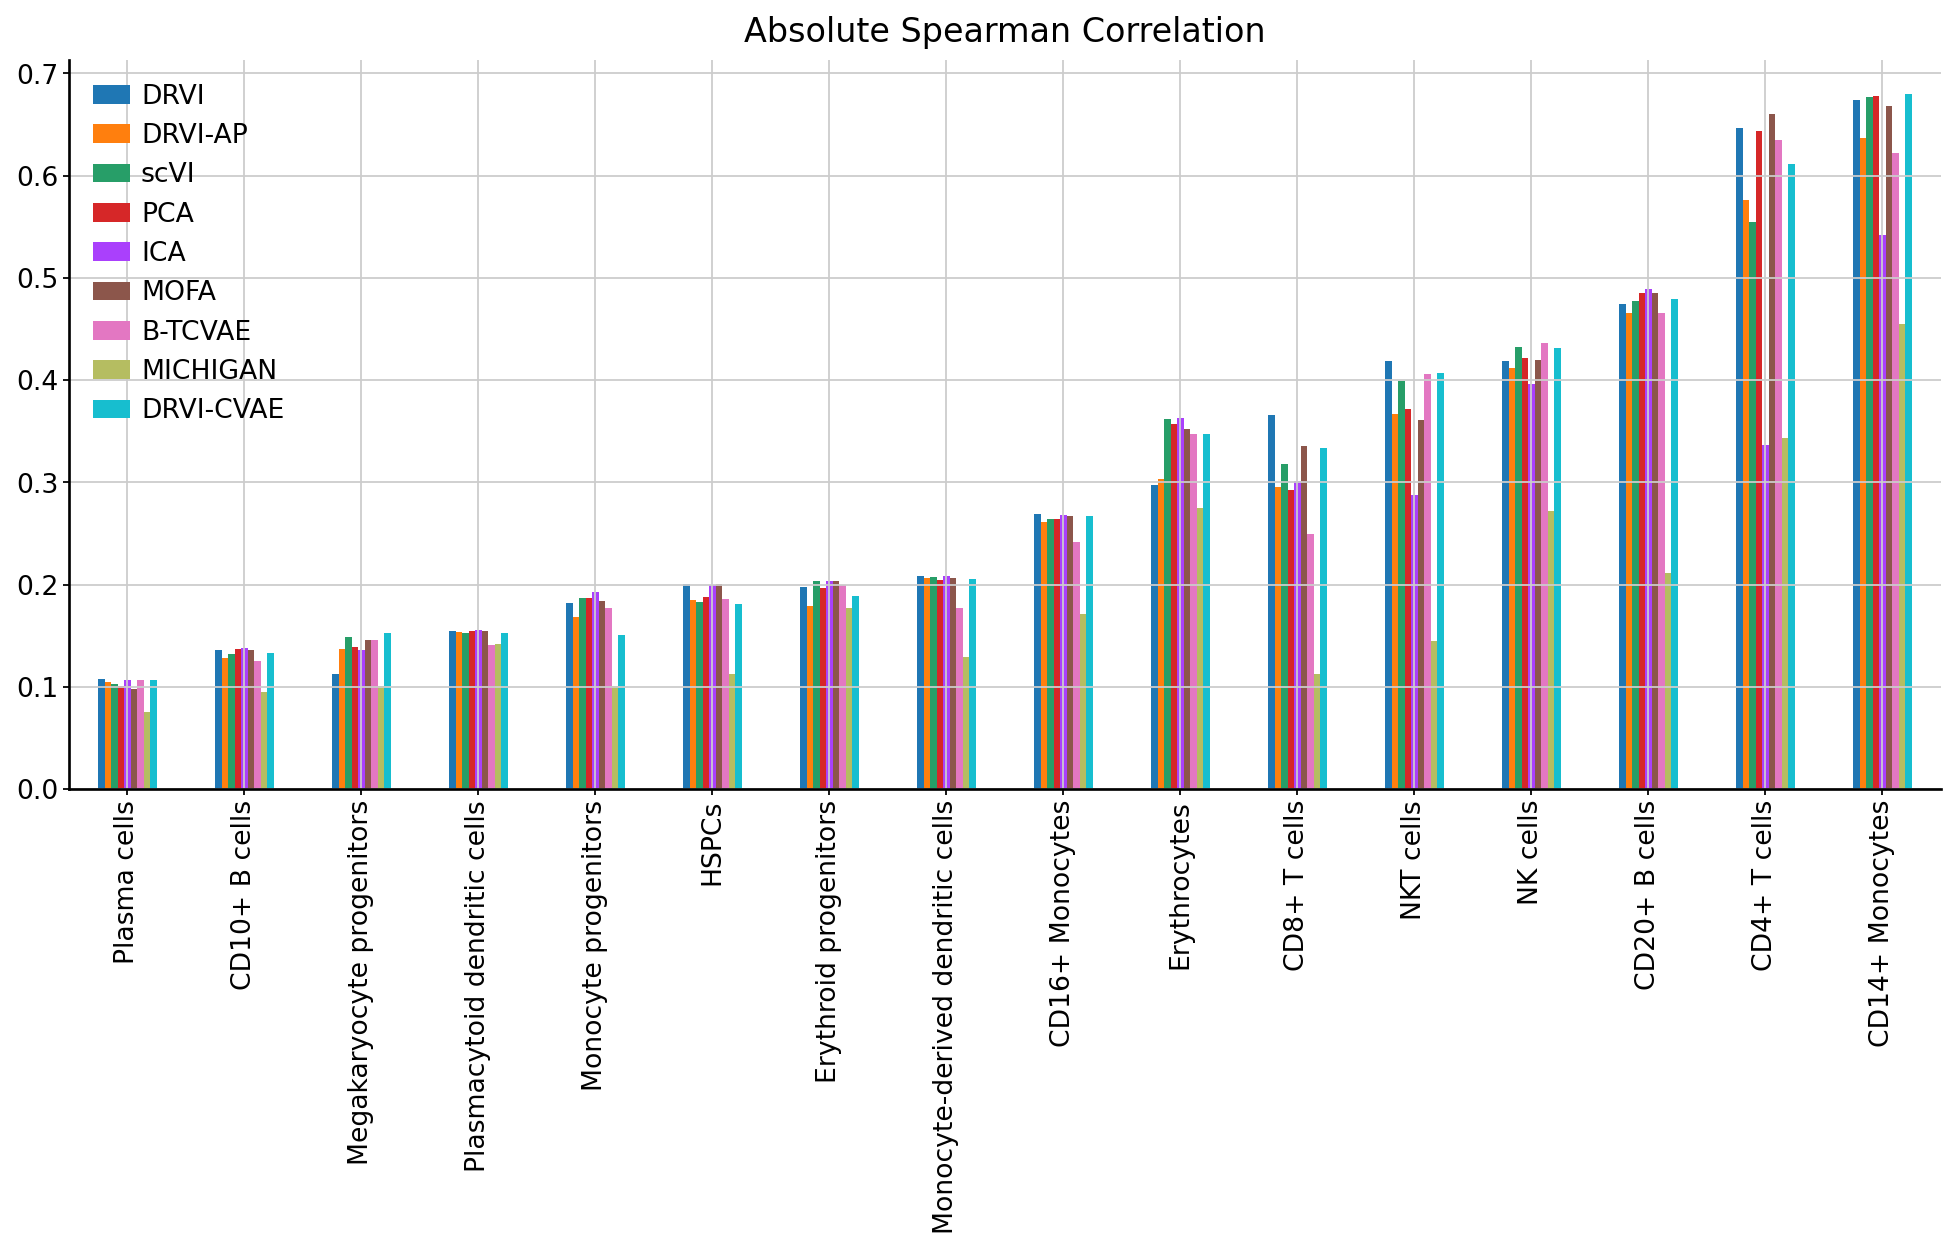

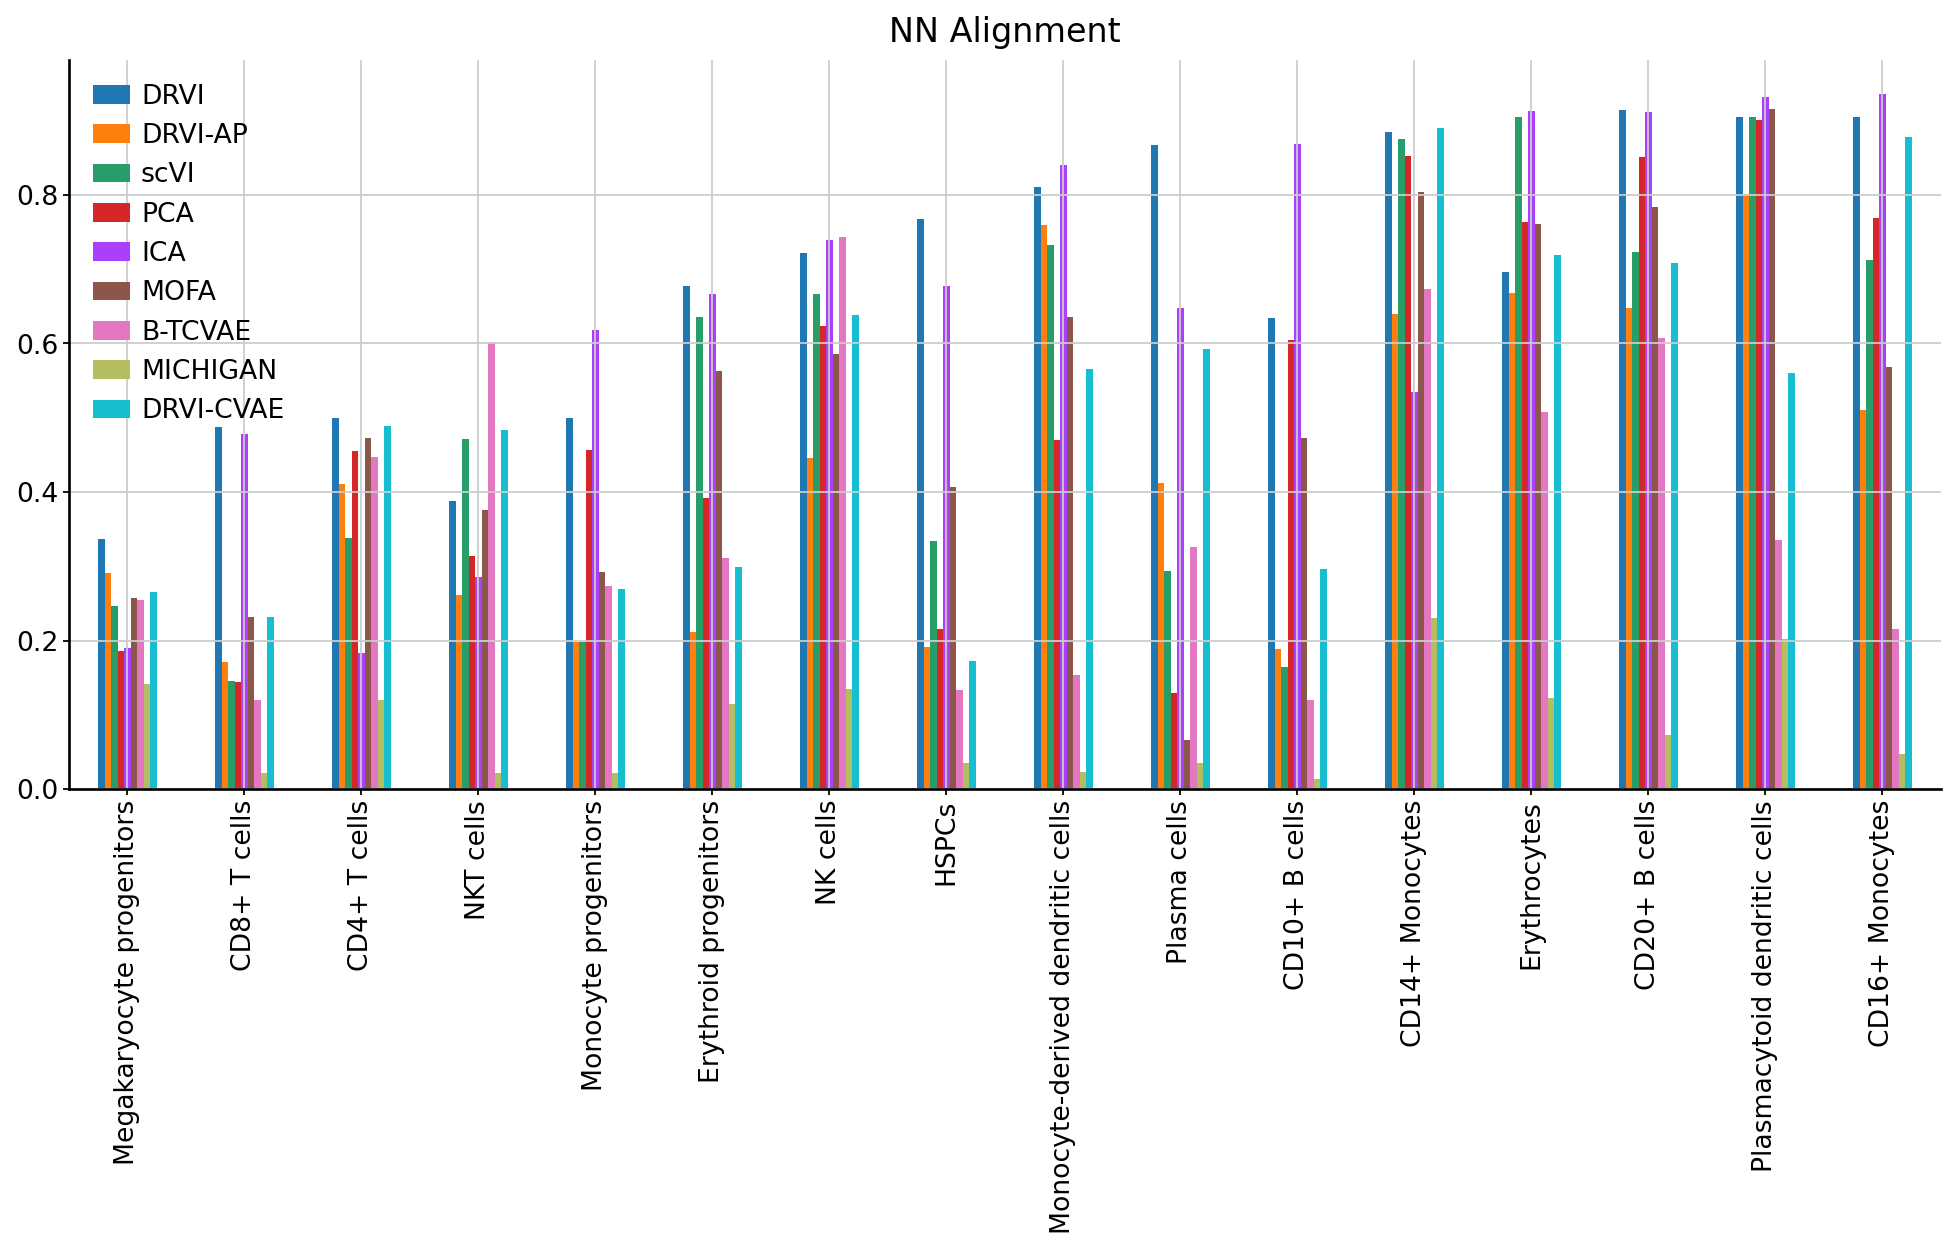

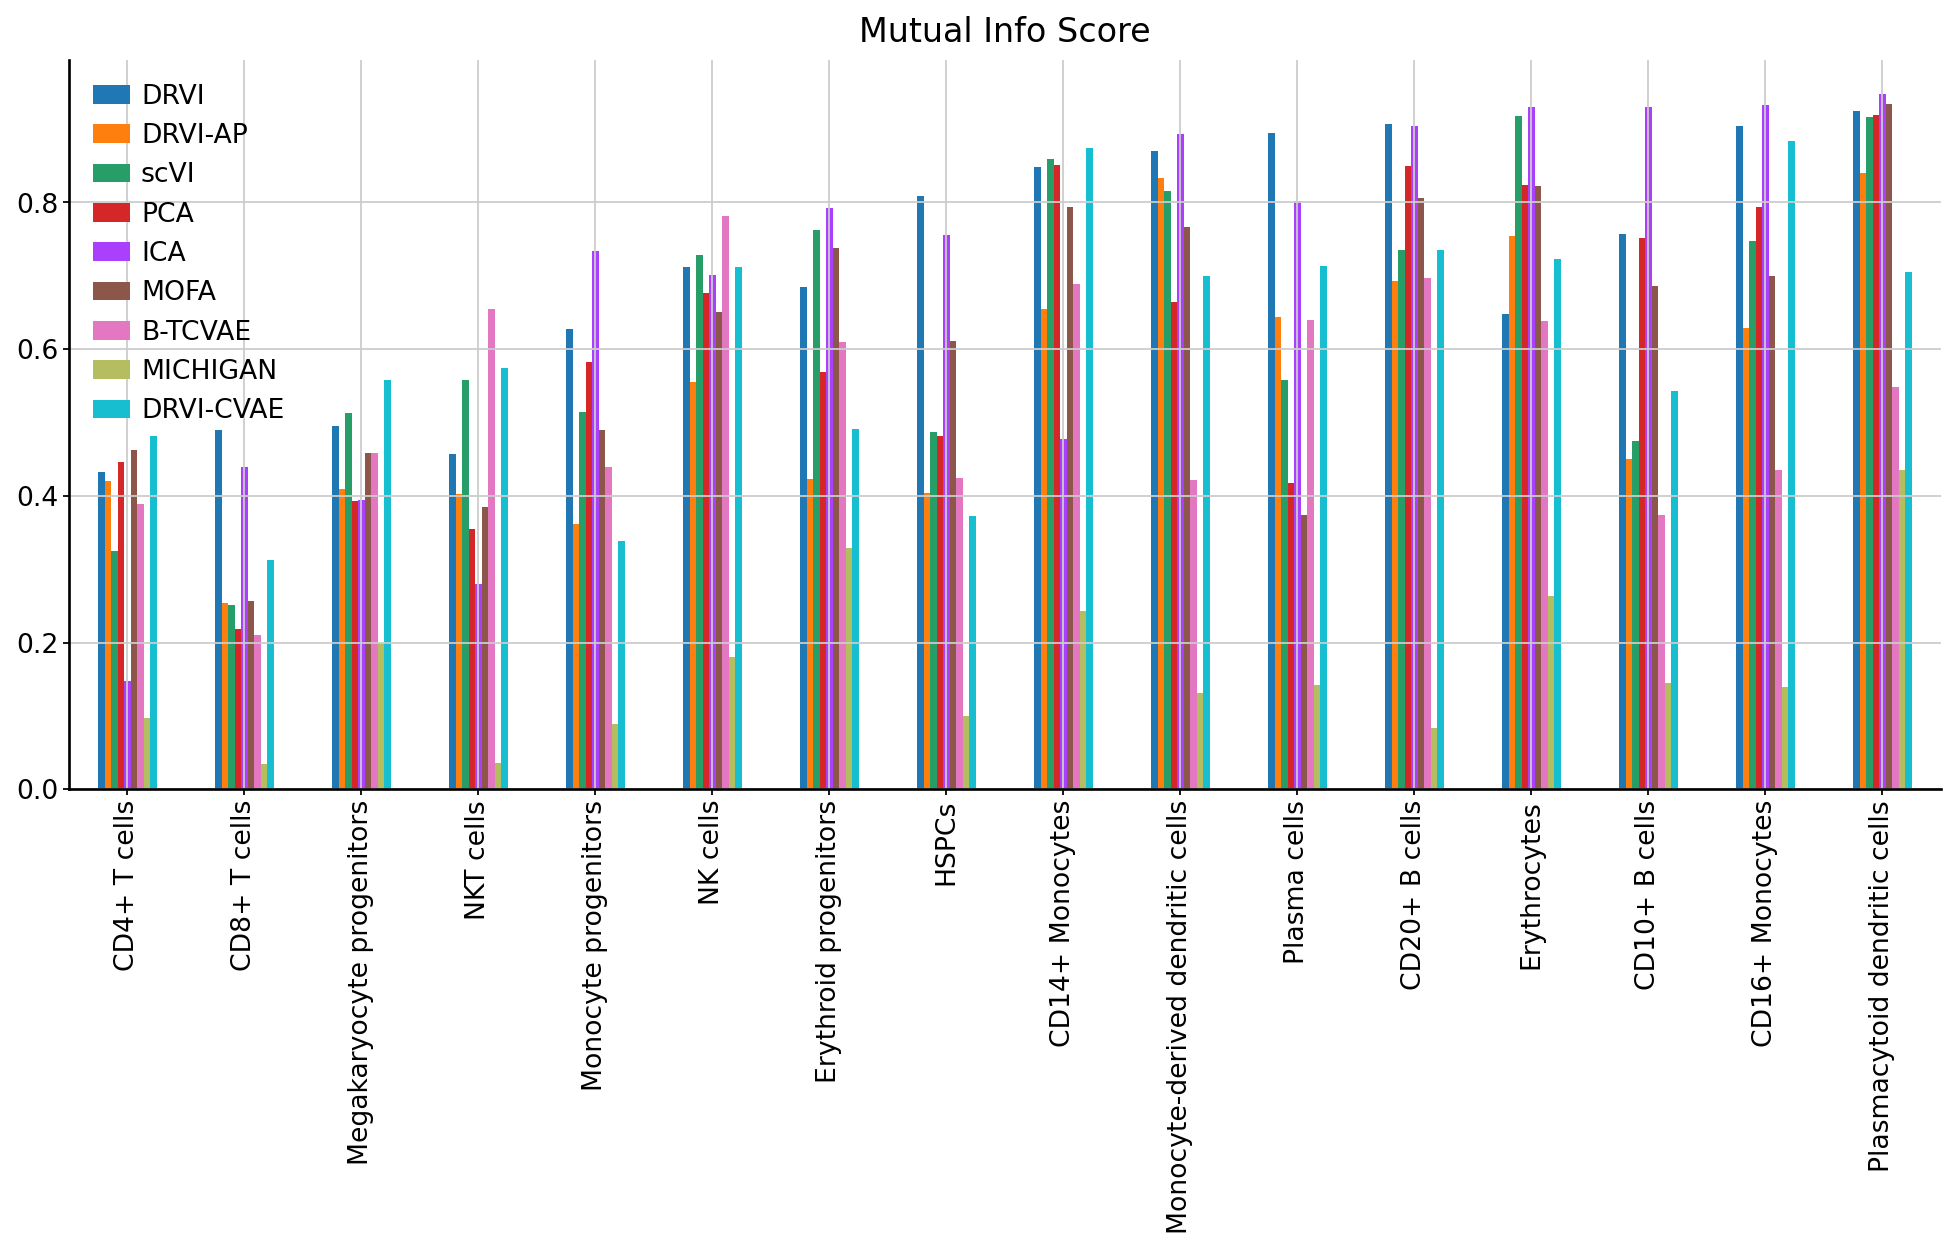

In [22]:
for metric_name in metrics.keys():
    comparative_df = pd.DataFrame({
        pretify_method_name(method_name): metric_results[method_name][metric_name].max(axis=0)
        for method_name in embeds.keys()
    })
    comparative_df['max'] = comparative_df.max(axis=1)
    comparative_df.sort_values('max', ascending=True).drop(columns=['max']).plot.bar(title=metric_name, figsize=(15, 6))
    comparative_df.to_csv(proj_dir / 'results' / f'eval_disentanglement_{run_name}_per_CT_max_{metric_name}.csv')
    plt.show()

In [23]:
final_df = []
for metric_name in metrics.keys():
    final_df.append(dict(metric=metric_name, **{
        pretify_method_name(method_name): latent_matching_score(metric_results[method_name][metric_name].values)
        for method_name in embeds.keys()
    }))
final_df = pd.DataFrame(final_df).set_index('metric')
final_df.to_csv(proj_dir / 'results' / f'eval_disentanglement_{run_name}_LMS.csv')
print('LMS')
final_df.T

LMS


metric     Absolute Spearman Correlation  NN Alignment  Mutual Info Score
DRVI                            0.302808      0.657006           0.699128
DRVI-AP                         0.283210      0.412149           0.531499
scVI                            0.267417      0.467490           0.553349
PCA                             0.281113      0.467813           0.559140
ICA                             0.259860      0.629613           0.670339
MOFA                            0.288121      0.464211           0.562161
B-TCVAE                         0.287738      0.332855           0.491483
MICHIGAN                        0.174226      0.080780           0.160854
DRVI-CVAE                       0.270220      0.422668           0.504929

In [24]:
proj_dir / 'results' / f'eval_disentanglement_{run_name}_LMS.csv'

PosixPath('/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public/results/eval_disentanglement_immune_hvg_LMS.csv')

In [25]:
final_df.T.iloc[0] / final_df.T.iloc[1:].max()

metric
Absolute Spearman Correlation    1.050974
NN Alignment                     1.043508
Mutual Info Score                1.042946
dtype: float64

<Axes: xlabel='metric'>

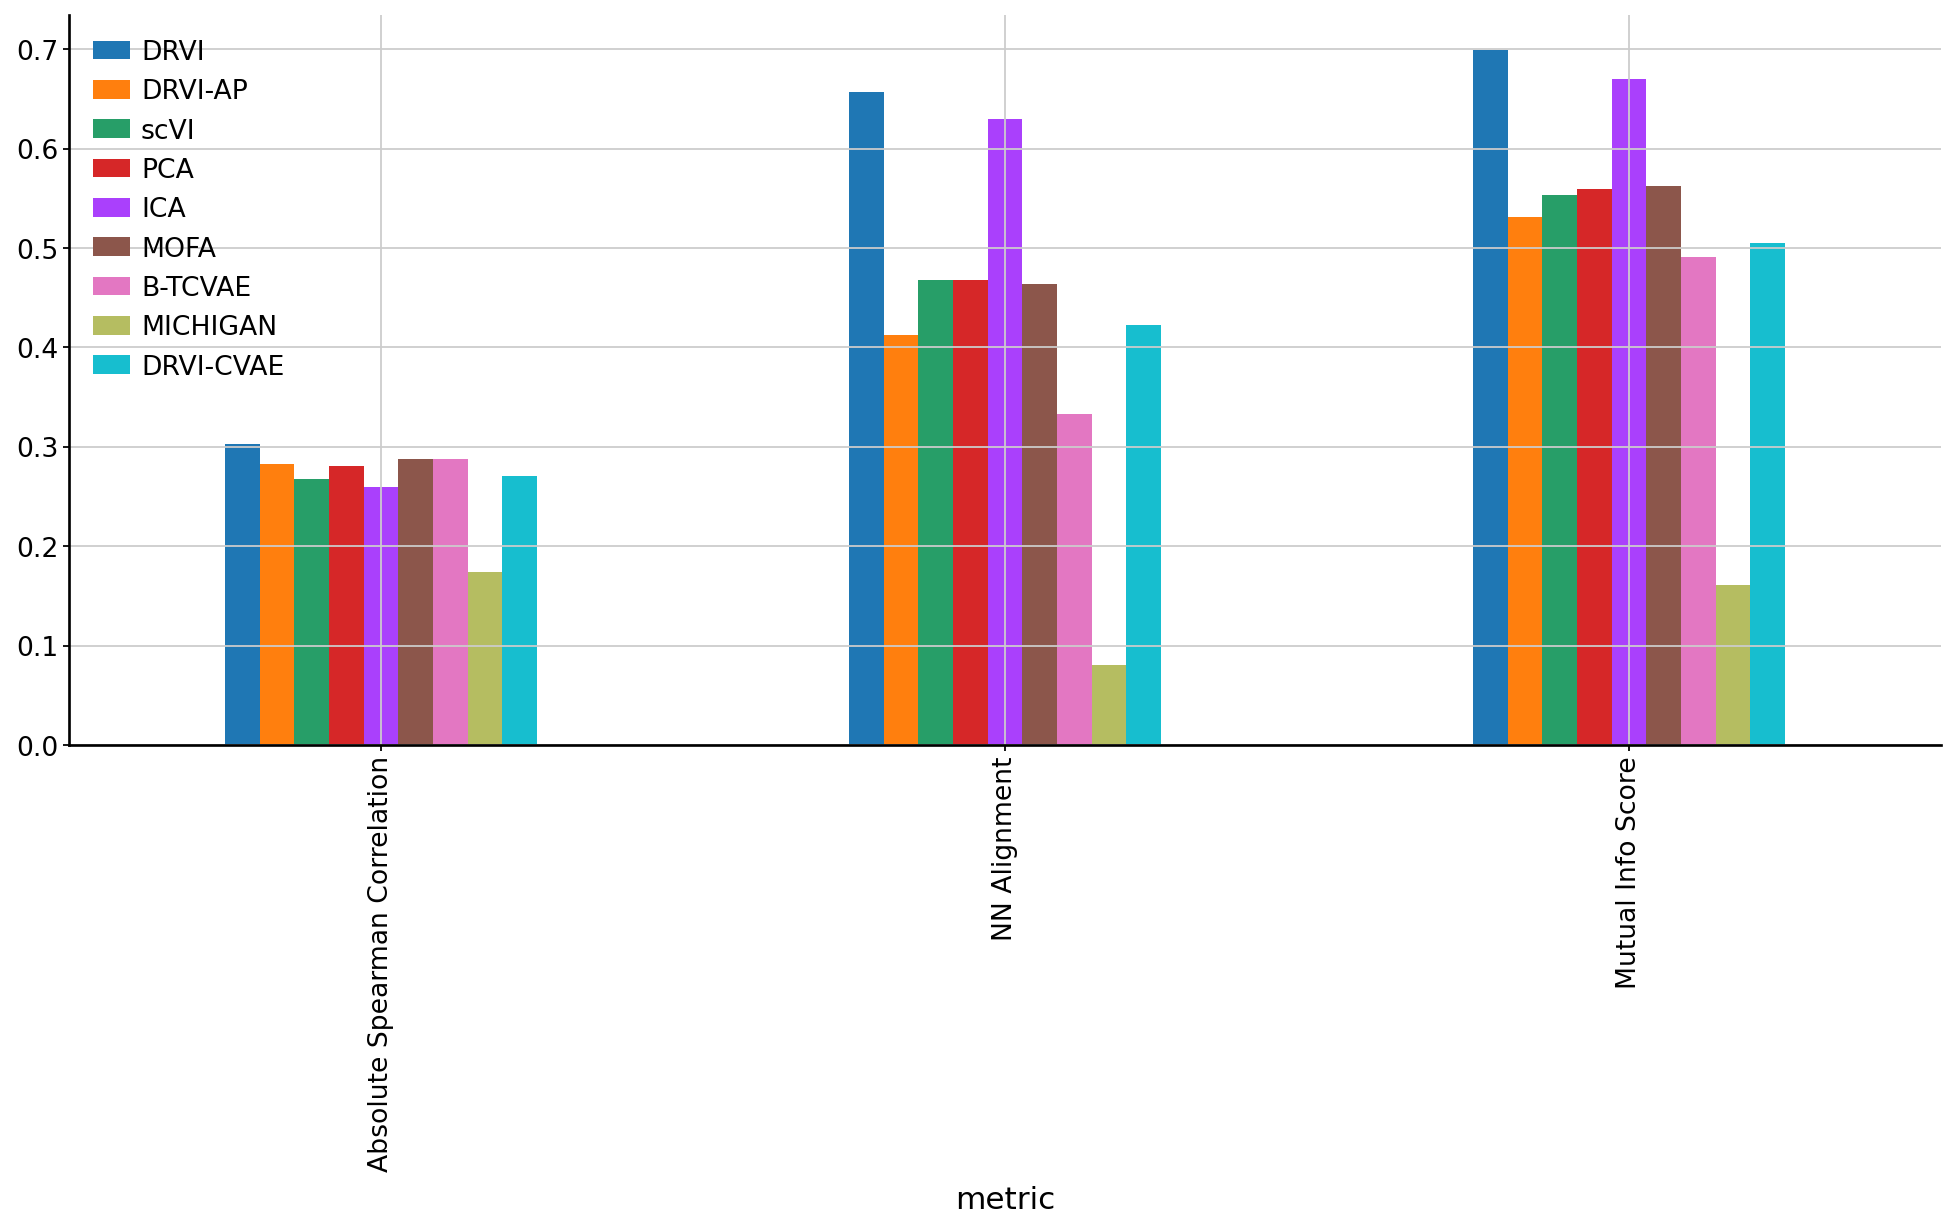

In [26]:
final_df.plot.bar(figsize=(15, 6))

In [27]:
if run_name == 'atac_nips21':
    plot_df = final_df.T.rename(columns={'Absolute Spearman Correlation': 'LMS-ASC',
                                         'NN Alignment': 'LMS-SPN',
                                         'Mutual Info Score': 'LMS-SMI',})
    plot_df.index.name = 'Method'
    plot_df.reset_index(inplace=True)
    plot_df = pd.melt(plot_df, id_vars=['Method'], var_name='metric', value_name='value')
    method_palette = {
        'DRVI': '#0072B2',
        'DRVI-AP': '#F0E442',
        'PeakVI': '#009E73',
        'PoissonVI': '#D55E00',
    }
    g = sns.barplot(plot_df,
                    x="metric", y="value", order=[f"LMS-SMI", f"LMS-SPN", f"LMS-ASC"],
                    hue='Method', 
                    hue_order=method_palette.keys(), palette=method_palette,
                   )
    g.set(xlabel=None)
    g.set(ylabel=None)
    plt.xticks(rotation=30)
    g.set(ylabel='Disentanglement\nmetric value')
    g.grid(False)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1.05), title='Method')
    plt.savefig(proj_dir / "plots" / f"eval_disentanglement_{run_name}_LMS.pdf", bbox_inches='tight')
    plt.show()

In [28]:
final_df = []
for metric_name in metrics.keys():
    final_df.append(dict(metric=metric_name, **{
        pretify_method_name(method_name): most_similar_averaging_score(metric_results[method_name][metric_name].values)
        for method_name in embeds.keys()
    }))
final_df = pd.DataFrame(final_df).set_index('metric')
final_df.to_csv(proj_dir / 'results' / f'eval_disentanglement_{run_name}_MSAS.csv')
print('MSAS')
final_df.T

MSAS


metric     Absolute Spearman Correlation  NN Alignment  Mutual Info Score
DRVI                            0.303993      0.687140           0.716224
DRVI-AP                         0.286398      0.425537           0.545405
scVI                            0.300237      0.521563           0.635049
PCA                             0.301269      0.507934           0.611902
ICA                             0.270271      0.651183           0.691344
MOFA                            0.304849      0.512028           0.620768
B-TCVAE                         0.291444      0.364018           0.525540
MICHIGAN                        0.182432      0.084838           0.165419
DRVI-CVAE                       0.301727      0.503605           0.607294

<Axes: xlabel='metric'>

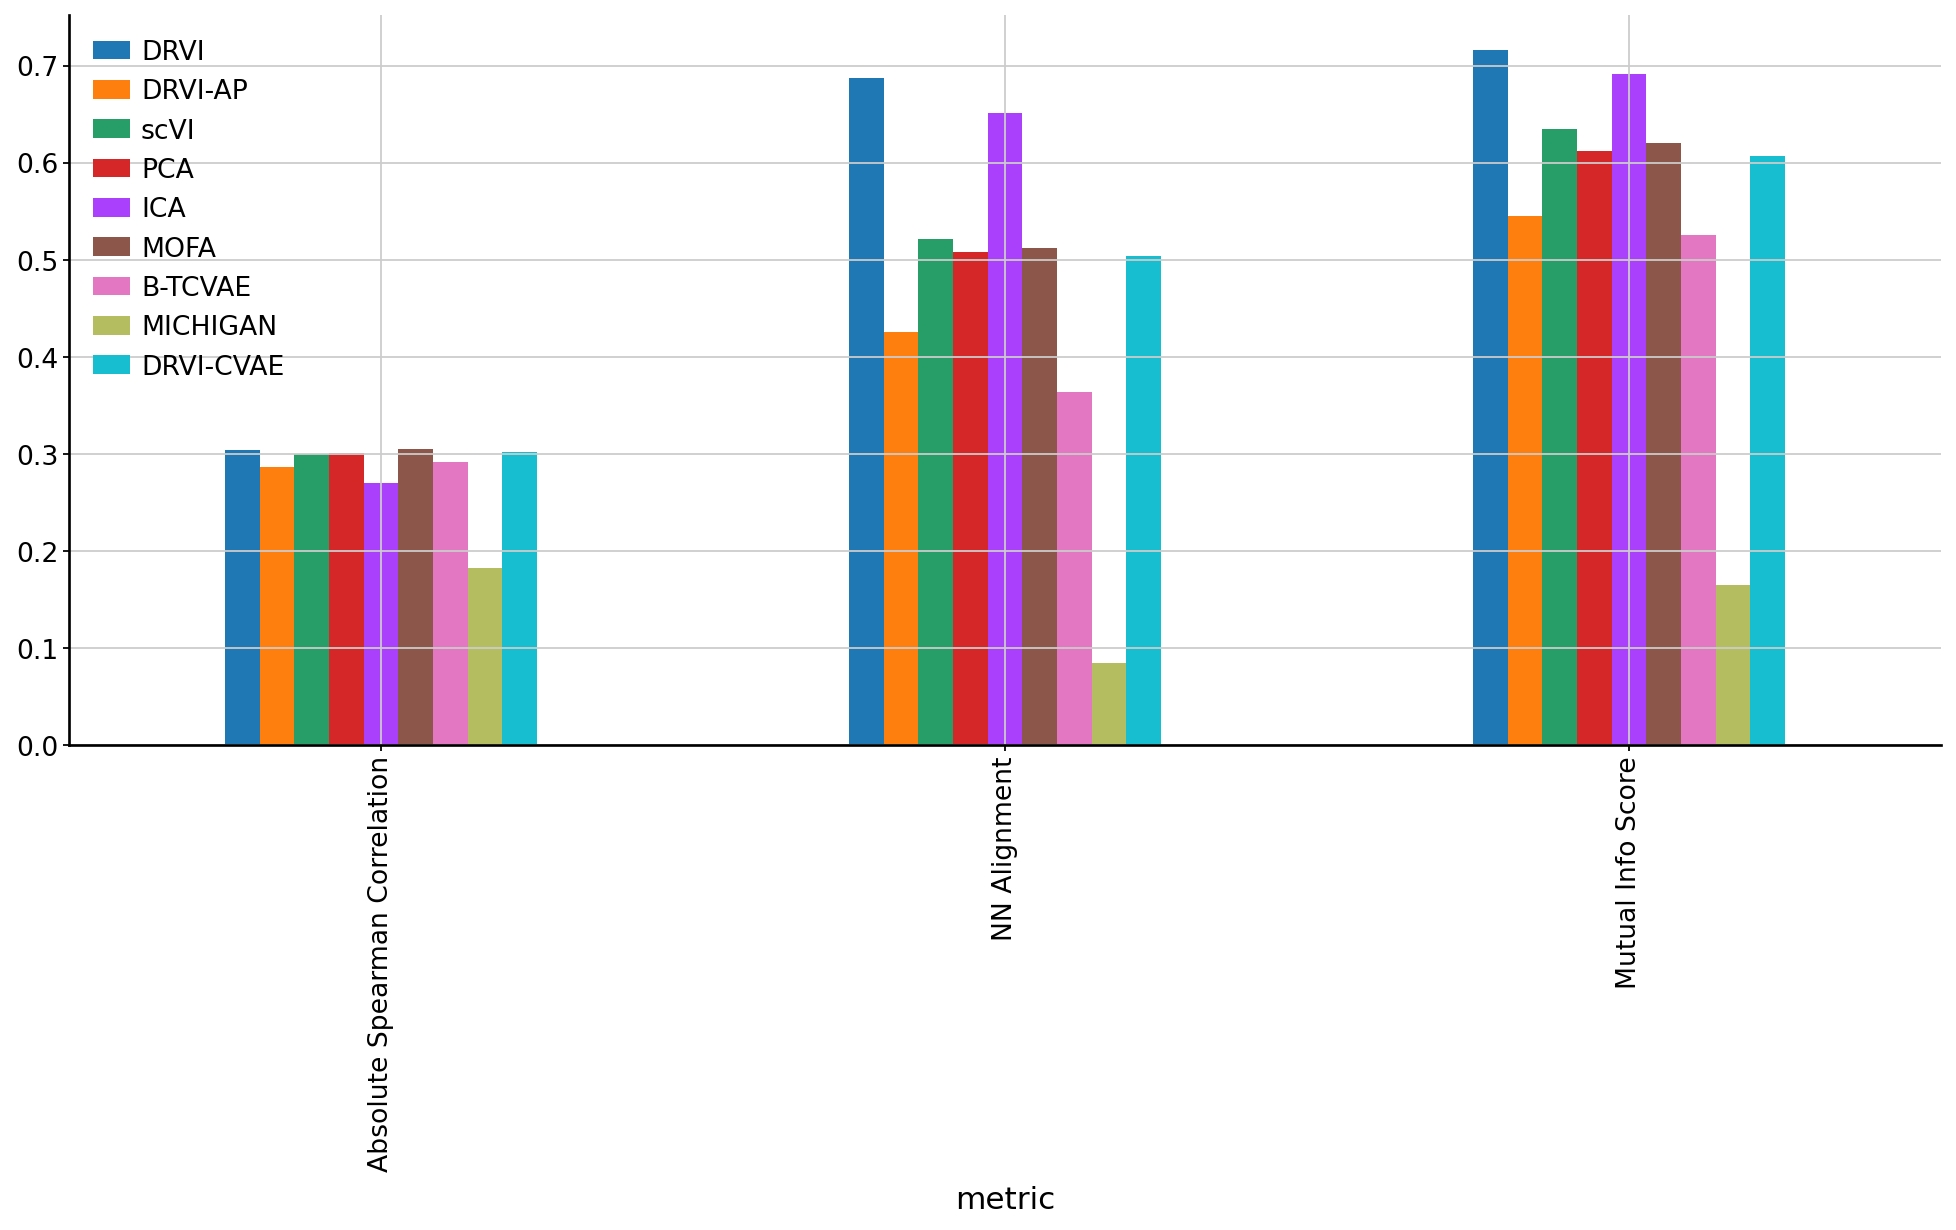

In [29]:
final_df.plot.bar(figsize=(15, 6))

In [30]:
final_df = []
for metric_name in metrics.keys():
    final_df.append(dict(metric=metric_name, **{
        pretify_method_name(method_name): most_similar_gap_score(metric_results[method_name][metric_name].values)
        for method_name in embeds.keys()
    }))
final_df = pd.DataFrame(final_df).set_index('metric')
final_df.to_csv(proj_dir / 'results' / f'eval_disentanglement_{run_name}_MSGS.csv')
print('MSGS')
final_df.T

MSGS


metric     Absolute Spearman Correlation  NN Alignment  Mutual Info Score
DRVI                            0.044425      0.333580           0.260163
DRVI-AP                         0.020445      0.118448           0.096412
scVI                            0.091103      0.354415           0.324459
PCA                             0.041469      0.185891           0.143231
ICA                             0.140087      0.514734           0.482640
MOFA                            0.032745      0.142312           0.116215
B-TCVAE                         0.024807      0.126749           0.119430
MICHIGAN                        0.028666      0.037202           0.061195
DRVI-CVAE                       0.082074      0.305691           0.269737

<Axes: xlabel='metric'>

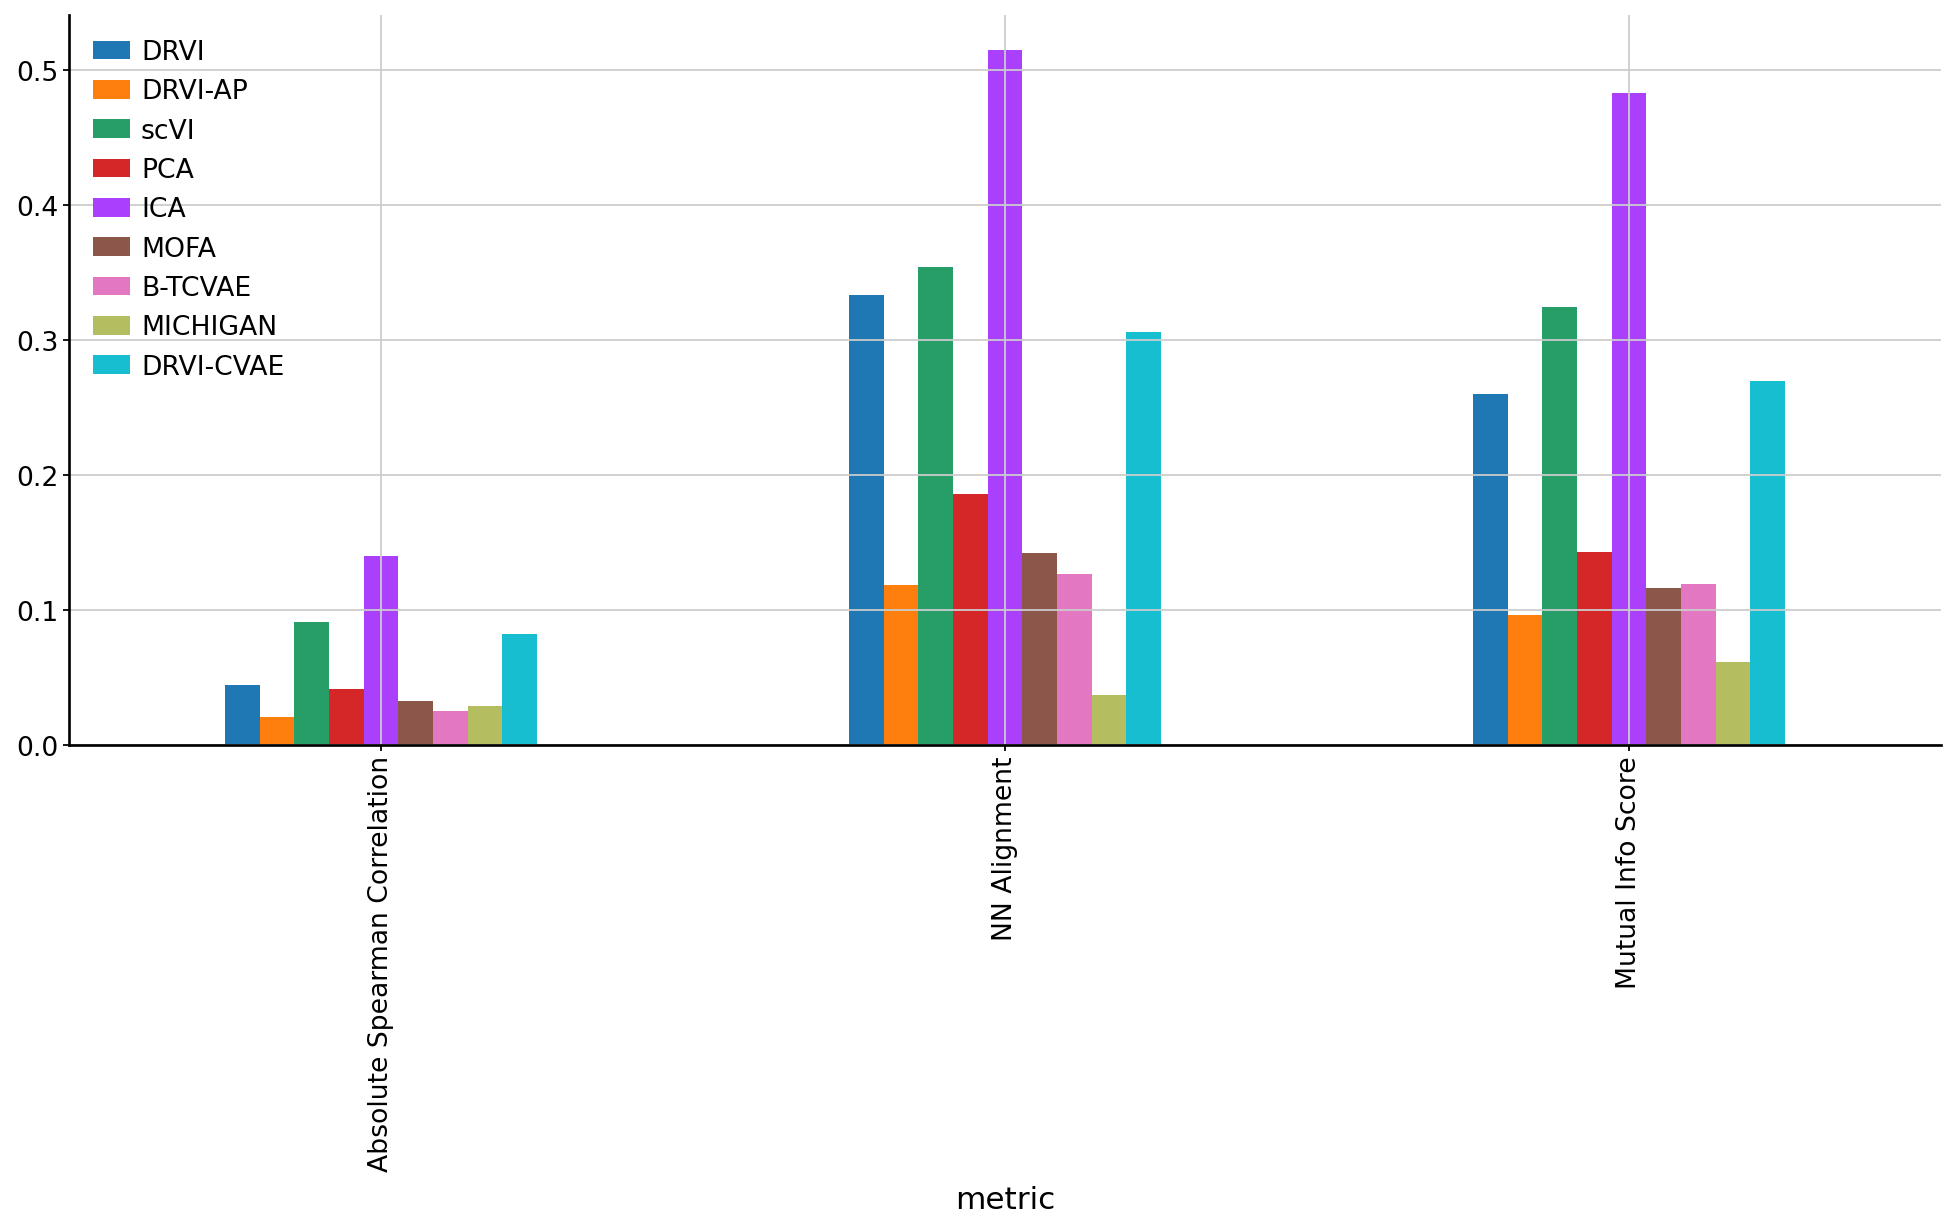

In [31]:
final_df.plot.bar(figsize=(15, 6))